This notebook esimates FFH/FFE using image segmentation results from GSV pano images and corresponding depth maps, and conducts assessment of results using ground-truth data.

## Load modules
* Functions on geometry restoration are contained in the geometry.py module.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import glob
from PIL import Image
from geometry import extract_feature_pixels_lowest_region, calculate_height_difference, estimate_FFH, estimate_FFE
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

## Set input folders of segmentation and depth images, ground-truth building points

In [3]:
# in_folder_predictions=r'D:\Wagga\GSV\Pano_clipped_predicted'
in_folder_predictions=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\GSV\Wagga\Pano_clipped_predicted'
in_folder_depth=r'D:\Wagga\GSV\Depth_clipped'
building_point_file=r'D:\Wagga\GSV\Final_Wagga_meta.geojson'

## Read in ground-truth data

In [4]:
gdf=gpd.read_file(building_point_file)
gdf.head()

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,Ground_surveyed,pano_id,lat_c,lng_c,heading,pitch,roll,elevation,date,geometry
0,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,721.960449,3.6338,-9999.0000,-9999.0,...,0,OhWlnnBJMpUtuvp3gak-8Q,-35.102543,147.349046,0.169123,-0.014912,6.252468,181.957260,2019-09,POINT (147.34855 -35.1025)
1,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,314.036351,3.4780,-9999.0000,-9999.0,...,0,None,NaN,NaN,NaN,NaN,NaN,NaN,None,POINT (147.34797 -35.10244)
2,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,1783.805231,3.2973,0.9431,-9999.0,...,0,None,NaN,NaN,NaN,NaN,NaN,NaN,None,POINT (147.34698 -35.10443)
3,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,346.207850,4.6240,-9999.0000,-9999.0,...,0,BLJvkN33DWrwpEKVa7q-wQ,-35.104924,147.348552,0.161009,0.002666,6.254132,181.549530,2019-09,POINT (147.34792 -35.10482)
4,Metal,1,Commercial,1,ROBERT,11 MOORONG STREET,615.235606,3.4026,-9999.0000,-9999.0,...,0,PoUl3uYBjG4p2dgCVbWo9g,-35.103220,147.348914,0.147912,0.003101,6.249268,181.555573,2019-09,POINT (147.34845 -35.10319)


## Read in segmentation image and corresponding depth map

In [5]:
prediction_files = glob.glob(os.path.join(in_folder_predictions,'*.png'))
prediction_file=prediction_files[0]
lbl_arr = np.asarray(Image.open(prediction_file))

In [6]:
pano_id=os.path.basename(prediction_file).split('.')[0]
print(pano_id)

--f-ozEFr3g-QueCRiD7wg


In [7]:
depth_file=os.path.join(in_folder_depth,os.path.basename(prediction_file).replace('.png','.tif'))
depth_arr=np.asarray(Image.open(depth_file))

Extract camera elevation:

In [8]:
elev_camera=gdf.loc[gdf['pano_id'] == pano_id, 'elevation'].values[0]
print(elev_camera)

182.2890625


## FFH/FFE Estimation
### Extract class masks and derive feature top/bottom
- segmentation class pixel values: 1:"foundation", 2:"front door", 3:"garage door", 4:"stairs"

In [9]:
# extract bottom pixels of foundation, stairs, front door and garage door
foundation_mask=(lbl_arr==1)
frontdoor_mask = (lbl_arr==2)
garagedoor_mask = (lbl_arr==3)
stairs_mask = (lbl_arr==4)
foundation_bottom_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="bottom")
stairs_bottom_pixels = extract_feature_pixels_lowest_region(stairs_mask, extract="bottom")
frontdoor_bottom_pixels = extract_feature_pixels_lowest_region(frontdoor_mask,extract="bottom")
garagedoor_bottom_pixels = extract_feature_pixels_lowest_region(garagedoor_mask,extract="bottom")

# extract top pixels of foundation and stairs
foundation_top_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="top")
stairs_top_pixels = extract_feature_pixels_lowest_region(stairs_mask,extract="top")

### Calculate height difference between feature top/bottom and camera

In [10]:
H_img = depth_arr.shape[0]  # Height of the cropped panorama
delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img)
delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img)
delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img)
delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img)
delta_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img)
delta_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img)

### Calculate FFH/FFE

In [11]:
# calculate FFH
FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
                   delta_foundation_bottom=delta_foundation_bottom,
                   delta_stairs_top=delta_stairs_top, 
                   delta_stairs_bottom=delta_stairs_bottom, 
                   delta_frontdoor_bottom=delta_frontdoor_bottom,
                   delta_garagedoor_bottom=delta_garagedoor_bottom)
print("Estimated First Floor Height (FFH):", FFH)

Estimated First Floor Height (FFH): 0


In [12]:
# calculate FFE
FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
                   delta_stairs_top=delta_stairs_top, 
                   delta_frontdoor_bottom=delta_frontdoor_bottom,
                   elev_camera=elev_camera)
print("Estimated First Floor Elevation (FFE):", FFE)

Estimated First Floor Elevation (FFE): 181.6625780081803


## Batch processing for all images
* This may take a while (more than an hour) depending on number of images to process.

In [14]:
FFH_all_predicted=[]
FFE_all_predicted=[]
pano_ids=[]
for prediction_file in prediction_files:
    # extract pano id
    pano_id=os.path.basename(prediction_file).split('.')[0]
    depth_file=os.path.join(in_folder_depth,os.path.basename(prediction_file).replace('.png','.tif'))
    if os.path.exists(depth_file):
        pano_ids.append(pano_id)
        print('pano id: ',pano_id)
        # read in corresponding depth map
        lbl_arr = np.asarray(Image.open(prediction_file))
        depth_arr=np.asarray(Image.open(depth_file))
        
        # extract camera elevation
        elev_camera=gdf.loc[gdf['pano_id'] == pano_id, 'elevation'].values
        if elev_camera.size>=0:
            elev_camera=elev_camera[0]
        print(elev_camera)

        # extract bottom pixels of foundation, stairs, front door and garage door
        foundation_mask=(lbl_arr==1)
        frontdoor_mask = (lbl_arr==2)
        garagedoor_mask = (lbl_arr==3)
        stairs_mask = (lbl_arr==4)
        foundation_bottom_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="bottom")
        stairs_bottom_pixels = extract_feature_pixels_lowest_region(stairs_mask, extract="bottom")
        frontdoor_bottom_pixels = extract_feature_pixels_lowest_region(frontdoor_mask,extract="bottom")
        garagedoor_bottom_pixels = extract_feature_pixels_lowest_region(garagedoor_mask,extract="bottom")

        # extract top pixels of foundation and stairs
        foundation_top_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="top")
        stairs_top_pixels = extract_feature_pixels_lowest_region(stairs_mask,extract="top")
        H_img = depth_arr.shape[0]  # Height of the cropped panorama

        # calculate height difference between feature top/bottom and camera
        delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img)
        delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img)
        delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img)
        delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img)
        delata_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img)
        delata_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img)
        
        # calculate FFH
        FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
                        delta_foundation_bottom=delta_foundation_bottom,
                        delta_stairs_top=delta_stairs_top, 
                        delta_stairs_bottom=delta_stairs_bottom, 
                        delta_frontdoor_bottom=delta_frontdoor_bottom,
                        delta_garagedoor_bottom=delta_garagedoor_bottom)
        # calculate FFE
        FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
                    delta_stairs_top=delta_stairs_top, 
                    delta_frontdoor_bottom=delta_frontdoor_bottom,
                    elev_camera=elev_camera)
        print("Estimated First Floor Height (FFH):", FFH)
        print("Estimated First Floor Elevation (FFE):", FFE)
        FFE_all_predicted.append(FFE)
        FFH_all_predicted.append(FFH)
    else:
        print('no depth map exists, skipping...')

pano id:  --f-ozEFr3g-QueCRiD7wg
182.2890625
Estimated First Floor Height (FFH): 0
Estimated First Floor Elevation (FFE): 181.6625780081803
pano id:  --w7nLX9fG5e3-B03RdsCg
183.7740936279297
Estimated First Floor Height (FFH): 0
Estimated First Floor Elevation (FFE): 181.04152022131558
pano id:  -2OAogqaVxTR2MwDTumzyw
184.1996459960938
Estimated First Floor Height (FFH): None
Estimated First Floor Elevation (FFE): 182.31838590025285
pano id:  -3cXQNaWNOFQLD_Xt5pn4Q
183.5959930419922
Estimated First Floor Height (FFH): None
Estimated First Floor Elevation (FFE): 181.45297155165983
pano id:  -4sIeKmIfb0XGfDjwlNE8g
182.5143585205078
Estimated First Floor Height (FFH): 0.00420640781498216
Estimated First Floor Elevation (FFE): 180.26024847278723
pano id:  -BgIJQhswWp2rB92b1mR1Q
183.9850921630859
Estimated First Floor Height (FFH): 0
Estimated First Floor Elevation (FFE): 182.0888267491658
pano id:  -bX8ZbO5__dkx3dJk0I-MA
180.3761596679688
Estimated First Floor Height (FFH): None
Estimated 

## Write estimated FFH/FFE back to building points file

In [15]:
gdf_updated=gdf.copy()
pano_id_to_FFH=dict(zip(pano_ids, FFH_all_predicted))
pano_id_to_FFE=dict(zip(pano_ids, FFE_all_predicted))
gdf_updated["FFH_GSV"] = gdf_updated['pano_id'].map(pano_id_to_FFH)
gdf_updated["FFE_GSV"] = gdf_updated['pano_id'].map(pano_id_to_FFE)

In [16]:
out_file=building_point_file.replace('.geojson','_FFH_GSV.geojson')
gdf_updated.to_file(out_file, driver="GeoJSON")

## Regression analysis and accuracy assessment
### FFH

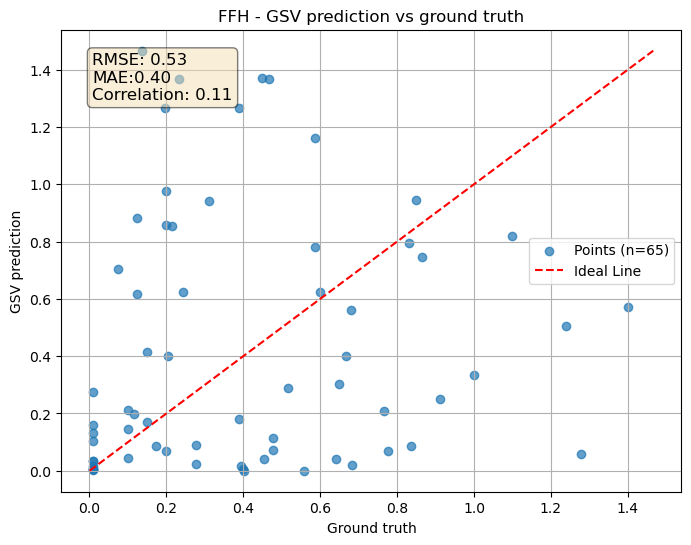

In [30]:
# filter out invalid prediction/groundtruth data
predicted_FFH=gdf_updated["FFH_GSV"]
gt_FFH=gdf_updated["Floor_height"]
# valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH)
valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH) &(predicted_FFH!=0)& (gt_FFH!=0.28)
# valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH) &(predicted_FFH!=0)
predicted_FFH = predicted_FFH[valid_indices]
gt_FFH = gt_FFH[valid_indices]

# Calculate RMSE and MAE
rmse = root_mean_squared_error(gt_FFH, predicted_FFH)
mae=mean_absolute_error(gt_FFH, predicted_FFH)
# Calculate Correlation Coefficient
correlation = np.corrcoef(gt_FFH, predicted_FFH)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(gt_FFH, predicted_FFH, alpha=0.7, label=f'Points (n={len(predicted_FFH)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted_FFH.min(), predicted_FFH.max()],[predicted_FFH.min(), predicted_FFH.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}\nMAE:{mae:.2f}\nCorrelation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - GSV prediction vs ground truth')
plt.xlabel('Ground truth')
plt.ylabel('GSV prediction')
plt.legend()
plt.grid()
# Show plot
plt.show()

### FFE

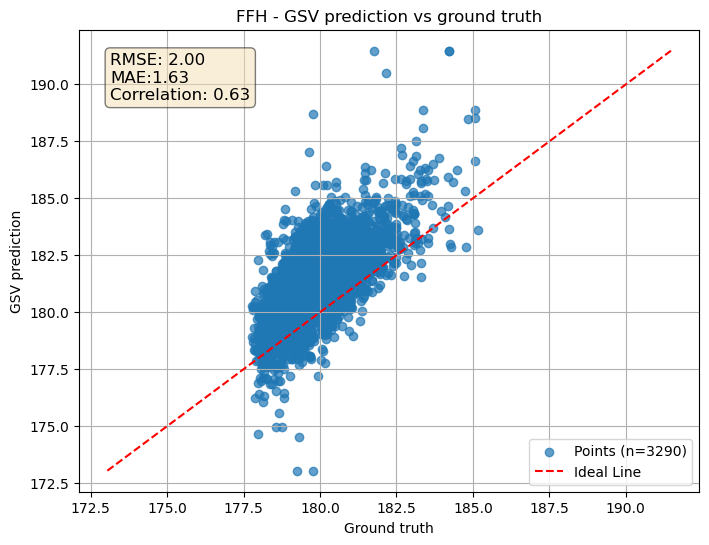

In [25]:
# filter out invalid prediction/groundtruth data
predicted_FFE=gdf_updated["FFE_GSV"]
gt_FFE=gdf_updated["Floor_Leve"]
valid_indices = ~np.isnan(predicted_FFE) & ~np.isnan(gt_FFE)
predicted_FFE = predicted_FFE[valid_indices]
gt_FFE = gt_FFE[valid_indices]

# Calculate RMSE and MAE
rmse_FFE = root_mean_squared_error(gt_FFE, predicted_FFE)
mae_FFE=mean_absolute_error(gt_FFE, predicted_FFE)
# Calculate Correlation Coefficient
correlation_FFE = np.corrcoef(gt_FFE, predicted_FFE)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(gt_FFE, predicted_FFE, alpha=0.7, label=f'Points (n={len(predicted_FFE)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted_FFE.min(), predicted_FFE.max()],[predicted_FFE.min(), predicted_FFE.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse_FFE:.2f}\nMAE:{mae_FFE:.2f}\nCorrelation: {correlation_FFE:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - GSV prediction vs ground truth')
plt.xlabel('Ground truth')
plt.ylabel('GSV prediction')
plt.legend()
plt.grid()
# Show plot
plt.show()

In [23]:
len(predicted_FFH)

65